In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
# from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [3]:
colors=['#9E8279',#'#65483D',
'#FDBF6E',
'#BC2041',
'#564C55',
'lightblue']
labels = ['+32 AFR','+12E/24A','+24E/12A','+32 EUR','+32 Greedy'] #be careful about the keys

In [4]:
# Strategy class. This is important since we want to load data from pickle
#     that is stored in the form of instances of this class
class Strat:
    def __init__(self,label,file_name,chr_num):
        self.label = label
        self.file_name = file_name
        self.ids = []
        self.chr_num = chr_num
    def read_ids(self):
        with open(self.file_name) as id_file:
            for line in id_file:
                self.ids.append(line.strip())
    def set_snp_list(self,snp_list):
        self.snp_list = snp_list
    def check_newones(self):
        self.head = self.snp_list.copy() #make a deep copy
        self.newones = []
        self.iterativenewones = []
        for index,id in enumerate(self.ids):
            
            new_snp_count = 0#self.snp_list-self.
            iterative_new_snp_count = 0
            file_name = f'./inds/allchr/{id}/chr{self.chr_num}.snplist'
            if not os.path.isfile(file_name):
                continue
            with open(file_name,'r') as snplistfile:
                
                for line in snplistfile:
                    snp = line.strip()
                    if snp in self.snp_list:
                        new_snp_count += 1
                    if snp in self.head:
                        iterative_new_snp_count += 1 
                        self.head.remove(snp)
            self.newones.append(new_snp_count)
            self.iterativenewones.append(iterative_new_snp_count)
        self.newones = np.array(self.newones)
        self.iterativenewones = np.array(self.iterativenewones)
        self.argsorted = np.argsort(self.newones)
    def check_overlaps(self,info,snp_dict):
        improvements = []
        removed_snp_set = set()
        titem = info[:,1].copy()
        for index,id in enumerate(self.ids):
            file_name = f'./inds/allchr/{id}/chr{self.chr_num}.snplist'
            if not os.path.isfile(file_name):
                continue
            with open(file_name,'r') as snplistfile:
                for line in snplistfile:
                    snp = line.strip()
                    if snp in snp_dict and snp not in removed_snp_set:
#                         print('found new one')
                        removed_snp_set.add(snp)
                        for item in snp_dict[snp]:
                            titem[item] -= 1
            improvements.append(titem)
        self.improvements = np.array(improvements)
        return self.improvements


In [5]:
#marker styles and colors for each super population 
marker_dict = {'AFR':'.','AMR':'^','EAS':'s','SAS':'p','EUR':'+'}
color_dict_super = {'AFR':'#e79a4b','AMR':'#ec5442','EAS':'#75bf7f','SAS':'#8676b6','EUR':'#3f8cb4'}
def set_marker(df):
    markers = []
    super_colors = []
    for item in df.iterrows():
        markers.append(marker_dict[item[1].values[1]])
        super_colors.append(color_dict_super[item[1].values[1]])
    df['marker'] = markers
    df['super_colors'] = super_colors


In [6]:
#here we load the results of the analysis script (extract_stats.py).
res_set = []
for i in range(1,23):
    res_set.append(pickle.load(open(f'./basic_res/res{i}.pkl','rb')))
    
    

In [7]:
#loading population related meta data
popinfo = {}
subpopdf = pd.read_csv('../subpops.csv',delimiter=',')

subpopdf.dropna(inplace=True)
subpopdf.set_index('sampleid',inplace=True)
for item in res_set[0][0]:
    tid_df = pd.read_csv(item.file_name,header=None)
    tid_df.set_index(0,inplace=True)
    tid_df = tid_df.join(subpopdf,how='inner')
    set_marker(tid_df)
    popinfo[item.label] = tid_df



In [8]:
#calculate the number of unique new items recovered by adding each sample
iterative_newones = {}
for item in res_set[0][0]:
    iterative_newones[item.label] = np.zeros((item.iterativenewones.shape))


In [9]:
#adding up newly recovered samples across chromosomes
for i in range(1,23):
    file_set = res_set[i-1][0]
    for item in file_set:
        iterative_newones[item.label] += item.iterativenewones


In [10]:
#occumulate the new items accross 
for key in iterative_newones:
    for i in range(1,iterative_newones[key].shape[0]):
        iterative_newones[key][i] += iterative_newones[key][i-1]
        

In [13]:
#some constants such as the total number of common variants per chromosome 
common_variant_counts = [1064609,1042062,883411,880884,791467,793684,754712,674864,620075,
                        660437,655536,617353,498606,402735,390624,399961,367784,381758,285494,
                         339157,215545,227833]
common_variants_count = np.sum(common_variant_counts)
#number of missing common SNVs when compared against Phase 1 samples
missing_snps_count = 0
for i in range(1,23):
    missing_snps_count += len(res_set[i-1][-1])
#this is the base line for the total fraction of common SNVs before adding new samples to the set
base_found_variants = 1-(missing_snps_count/common_variants_count)    

In [14]:
#here we calculate exactly how many common variants new samples iteratively recover in the evaluation set. 
iterative_new_percentages = {}
for item in res_set[0][0]:
    iterative_new_percentages[item.label] = np.zeros((item.iterativenewones.shape))

for i in range(1,23):
    for item in file_set:
        iterative_new_percentages[item.label] += item.iterativenewones / common_variant_counts[i-1]


In [15]:
for strat in iterative_newones:
    iterative_newones[strat] = iterative_newones[strat][:32]

/sc/arion/projects/kennylab/roohy/conda/envs/nukbb/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


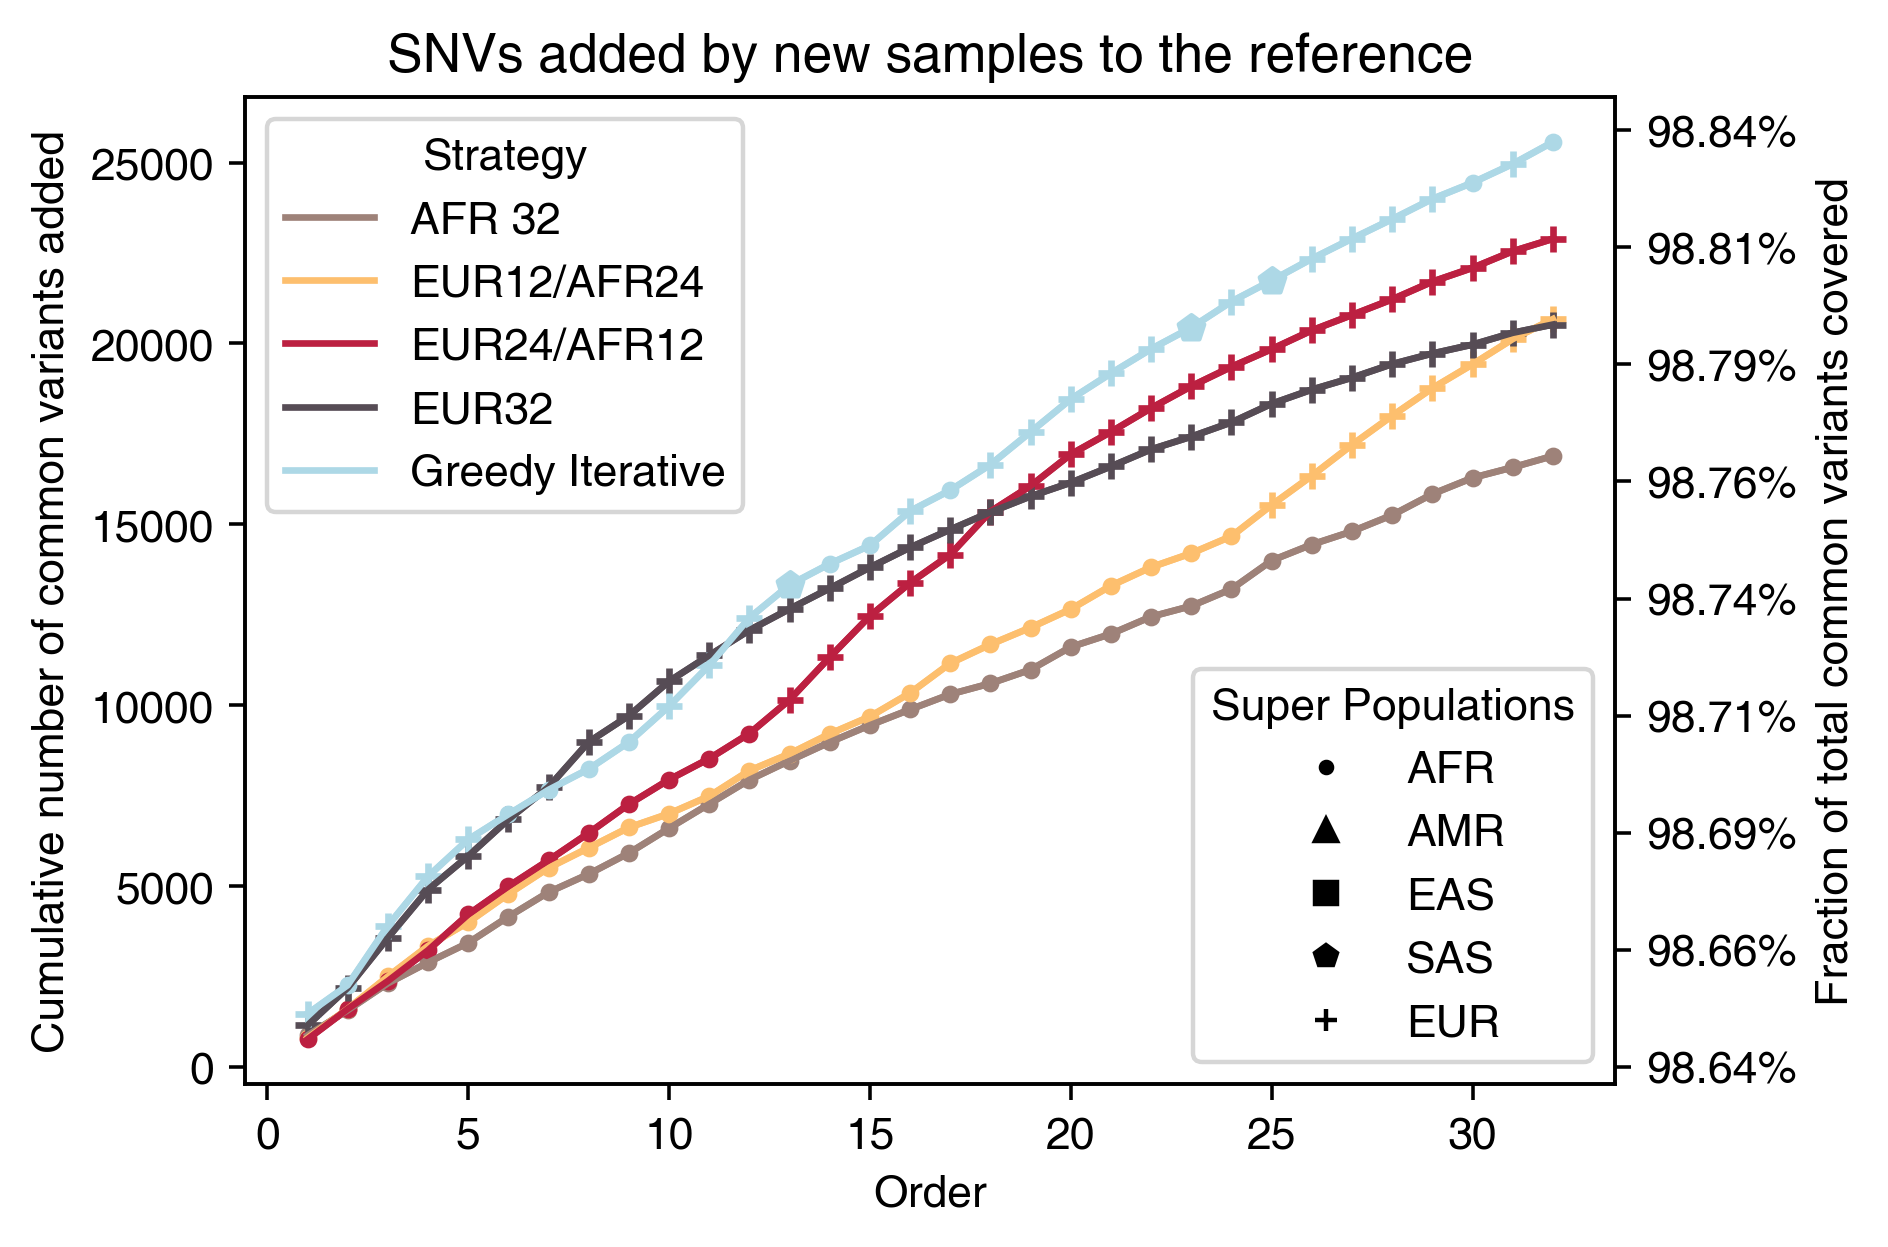

In [16]:
fig,ax = plt.subplots(dpi=320)

for index,strat in enumerate(iterative_newones.keys()):
    xvals = np.arange(1,iterative_newones[strat].shape[0]+1)
    ax.plot(xvals,iterative_newones[strat],label=strat,color=colors[index])

# ax.set_yscale('log')

ax.set_title('SNVs added by new samples to the reference')
# fig.text(0.5, 0.04, 'common X', ha='center')
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
first_legend = ax.legend(title="Strategy")
ax.add_artist(first_legend)
ax.set_ylabel('Cumulative number of common variants added')
ax.set_xlabel('Order')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
for index,strat in enumerate(iterative_newones.keys()):
    xvals = np.arange(1,iterative_newones[strat].shape[0]+1)
    yvals = iterative_newones[strat]/common_variants_count
    ax2.plot(xvals,yvals,color=colors[index])
    for xval in xvals:
        ax2.scatter(xval,yvals[xval-1],marker=popinfo[strat]['marker'].values[xval-1],color=colors[index])
#     ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)
ax2.set_yticklabels(f'{tickval:.2f}%' for tickval in 100*(ax2.get_yticks()+base_found_variants))

ax2.set_ylabel('Fraction of total common variants covered')
second_legend_elements = []
for item in marker_dict:
    second_legend_elements.append(Line2D([0],[0],marker=marker_dict[item],color='black',label=item,
                                        markersize=5,linewidth=0))
ax.legend(handles=second_legend_elements, loc='lower right',title="Super Populations")
fig.tight_layout()





## Improvements

In [17]:
improvements = {}
improvements_percent = {}
total_counts = np.array([res_set[i-1][1] for i in range(1,23)]).sum(axis=0) #22x2105 collapsed on first axis -> 2015

for item in res_set[0][0]:
    improvements[item.label] = np.zeros((item.improvements.shape))
    #improvements_percent[item.label] = np.zeros((item.improvements.shape))
    
for i in range(1,23):
    file_set = res_set[i-1][0]
    for item in file_set:
        improvements[item.label] += item.improvements
for item in file_set:
    improvements_percent[item.label] = 100*improvements[item.label]/total_counts
for item in file_set:
    improvements[item.label] = improvements[item.label][:32,:] 
    improvements_percent[item.label] =  improvements_percent[item.label][:32,:]

AFR 32
EUR12/AFR24
EUR24/AFR12
EUR32
Greedy Iterative


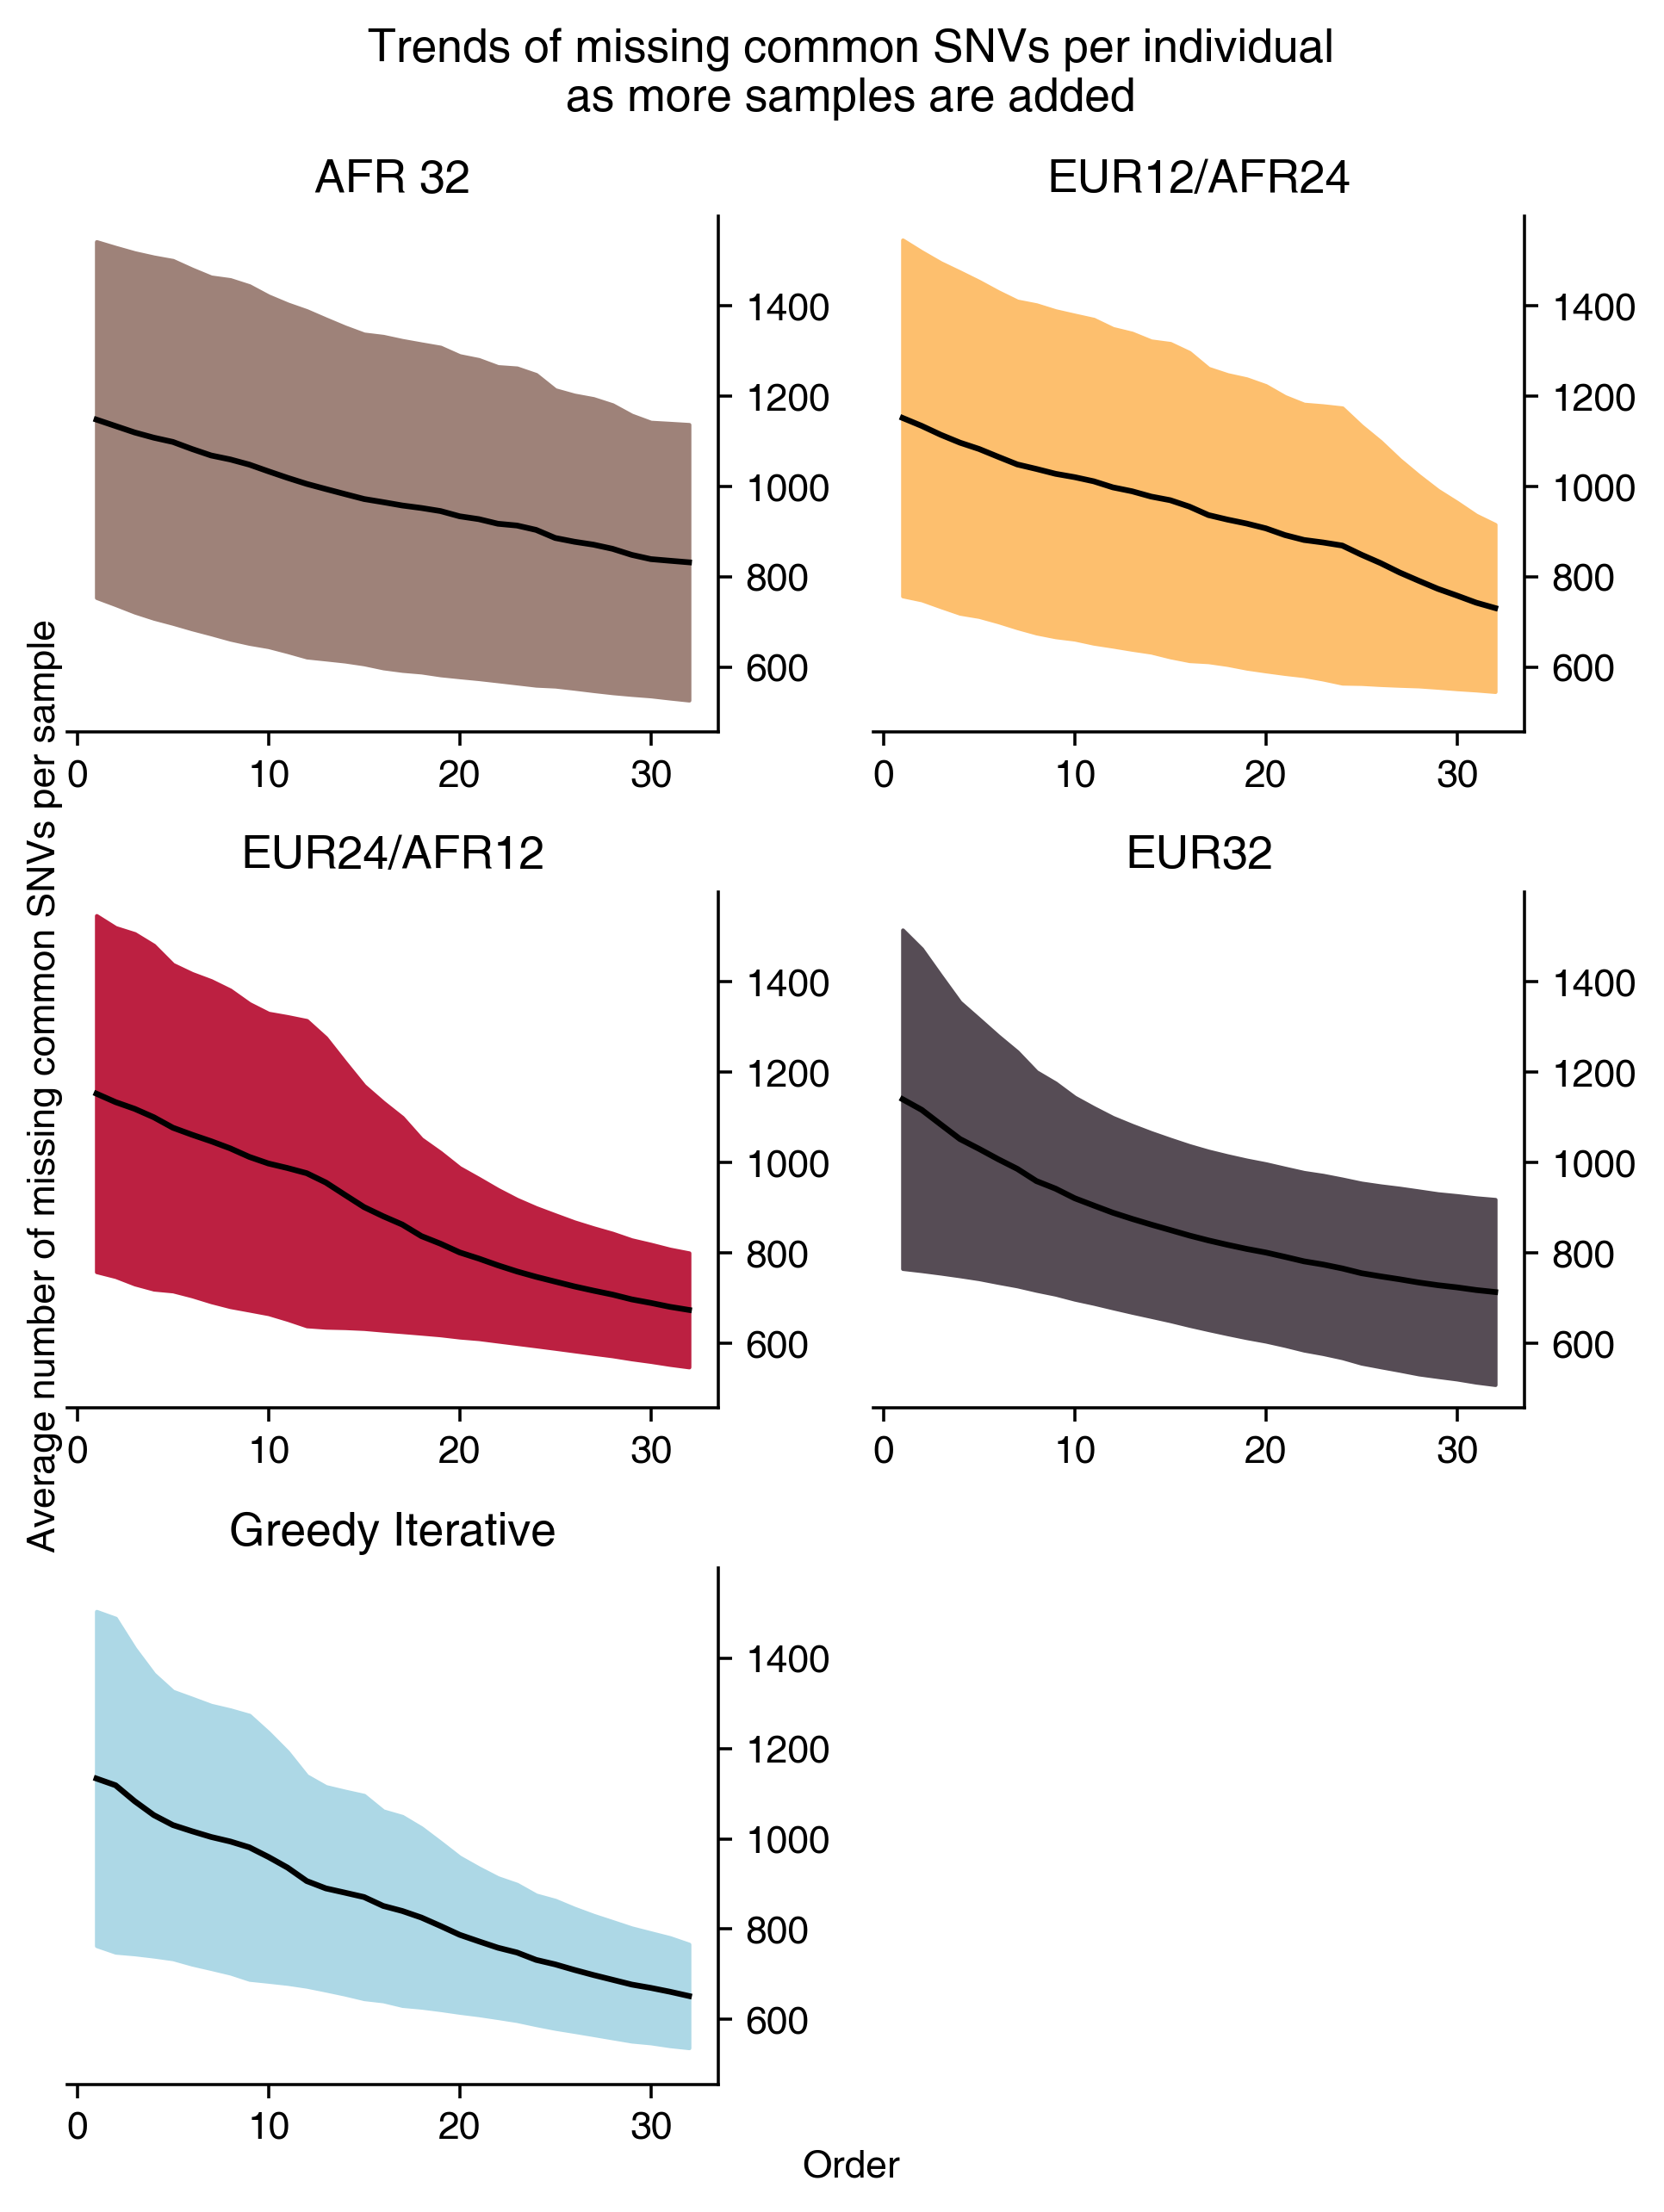

In [18]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,dpi=320,sharey=True,figsize=(6,8))
ax_list = ax_list.flatten()
for index,strat in enumerate(iterative_newones.keys()):

    ax = ax_list[index]
    means = improvements[strat].mean(axis=1)
    std = improvements[strat].std(axis=1)
    
    x = np.arange(improvements[strat].shape[0])+1
    ax.plot(x,means,'-k')
    ax.fill_between(x, means-std, means+std,color=colors[index])
    ax.set_title(strat)
    
#     for xval in x:
#         ax.scatter(xval,yvals[xval-1],marker=popinfo[strat]['marker'].values[xval-1])#,color=colors[index])
    
    if index == 0 or index == 2:
#         pass
#         ax.axes.get_yaxis().set_visible(False)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    else:
        
        ax.axes.get_yaxis().set_visible(True)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
        
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    print(strat)
fig.suptitle('Trends of missing common SNVs per individual\n'+
            'as more samples are added')

fig.text(0.5, 0.005, 'Order', ha='center')
fig.text(0.002, 0.5, 'Average number of missing common SNVs per sample', va='center', rotation='vertical')
ax_list[-1].axis('off')
fig.tight_layout()



AFR 32
EUR12/AFR24
EUR24/AFR12
EUR32
Greedy Iterative


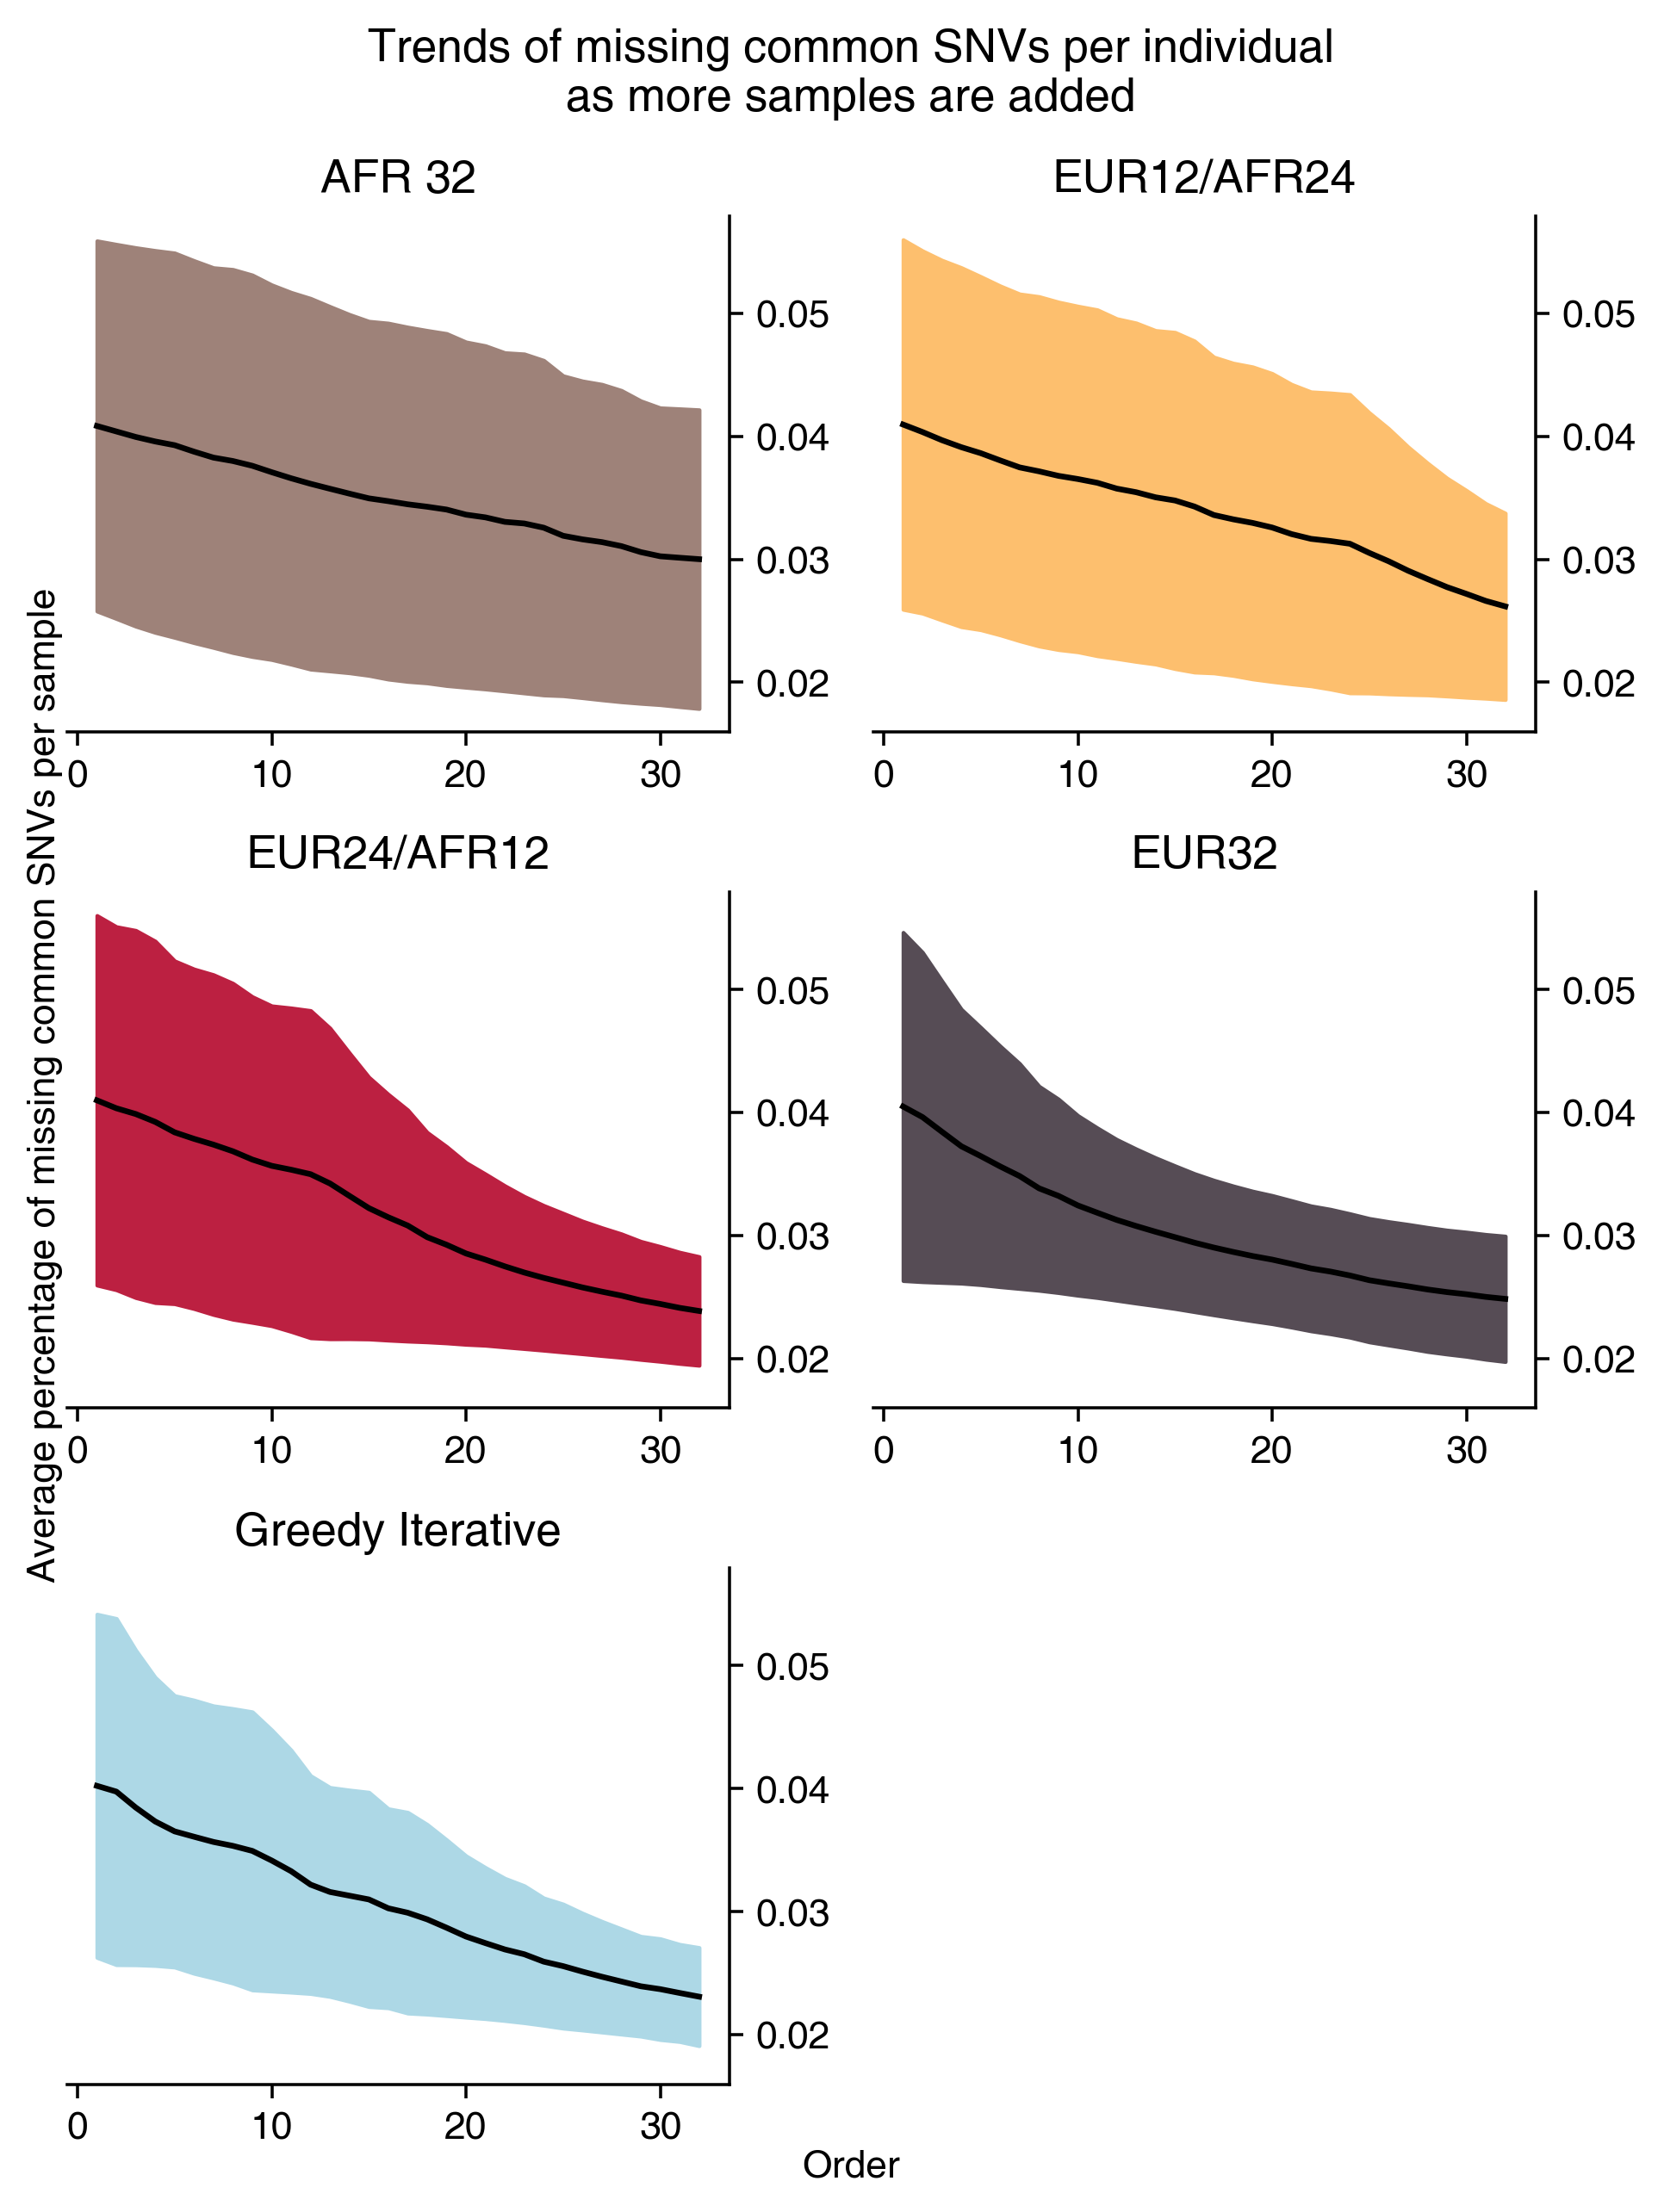

In [22]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,dpi=320,sharey=True,figsize=(6,8))
ax_list = ax_list.flatten()
for index,strat in enumerate(iterative_newones.keys()):

    ax = ax_list[index]
    means = improvements_percent[strat].mean(axis=1)
    std = improvements_percent[strat].std(axis=1)
    
    x = np.arange(improvements_percent[strat].shape[0])+1
    ax.plot(x,means,'-k')
    ax.fill_between(x, means-std, means+std,color=colors[index])
    ax.set_title(strat)
    
#     for xval in x:
#         ax.scatter(xval,yvals[xval-1],marker=popinfo[strat]['marker'].values[xval-1])#,color=colors[index])
    
    if index == 0 or index == 2:
#         pass
#         ax.axes.get_yaxis().set_visible(False)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    else:
        
        ax.axes.get_yaxis().set_visible(True)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
        
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    print(strat)
fig.suptitle('Trends of missing common SNVs per individual\n'+
            'as more samples are added')

fig.text(0.5, 0.005, 'Order', ha='center')
fig.text(0.002, 0.5, 'Average percentage of missing common SNVs per sample', va='center', rotation='vertical')
ax_list[-1].axis('off')
fig.tight_layout()




AFR 32
EUR12/AFR24
EUR24/AFR12
EUR32
Greedy Iterative


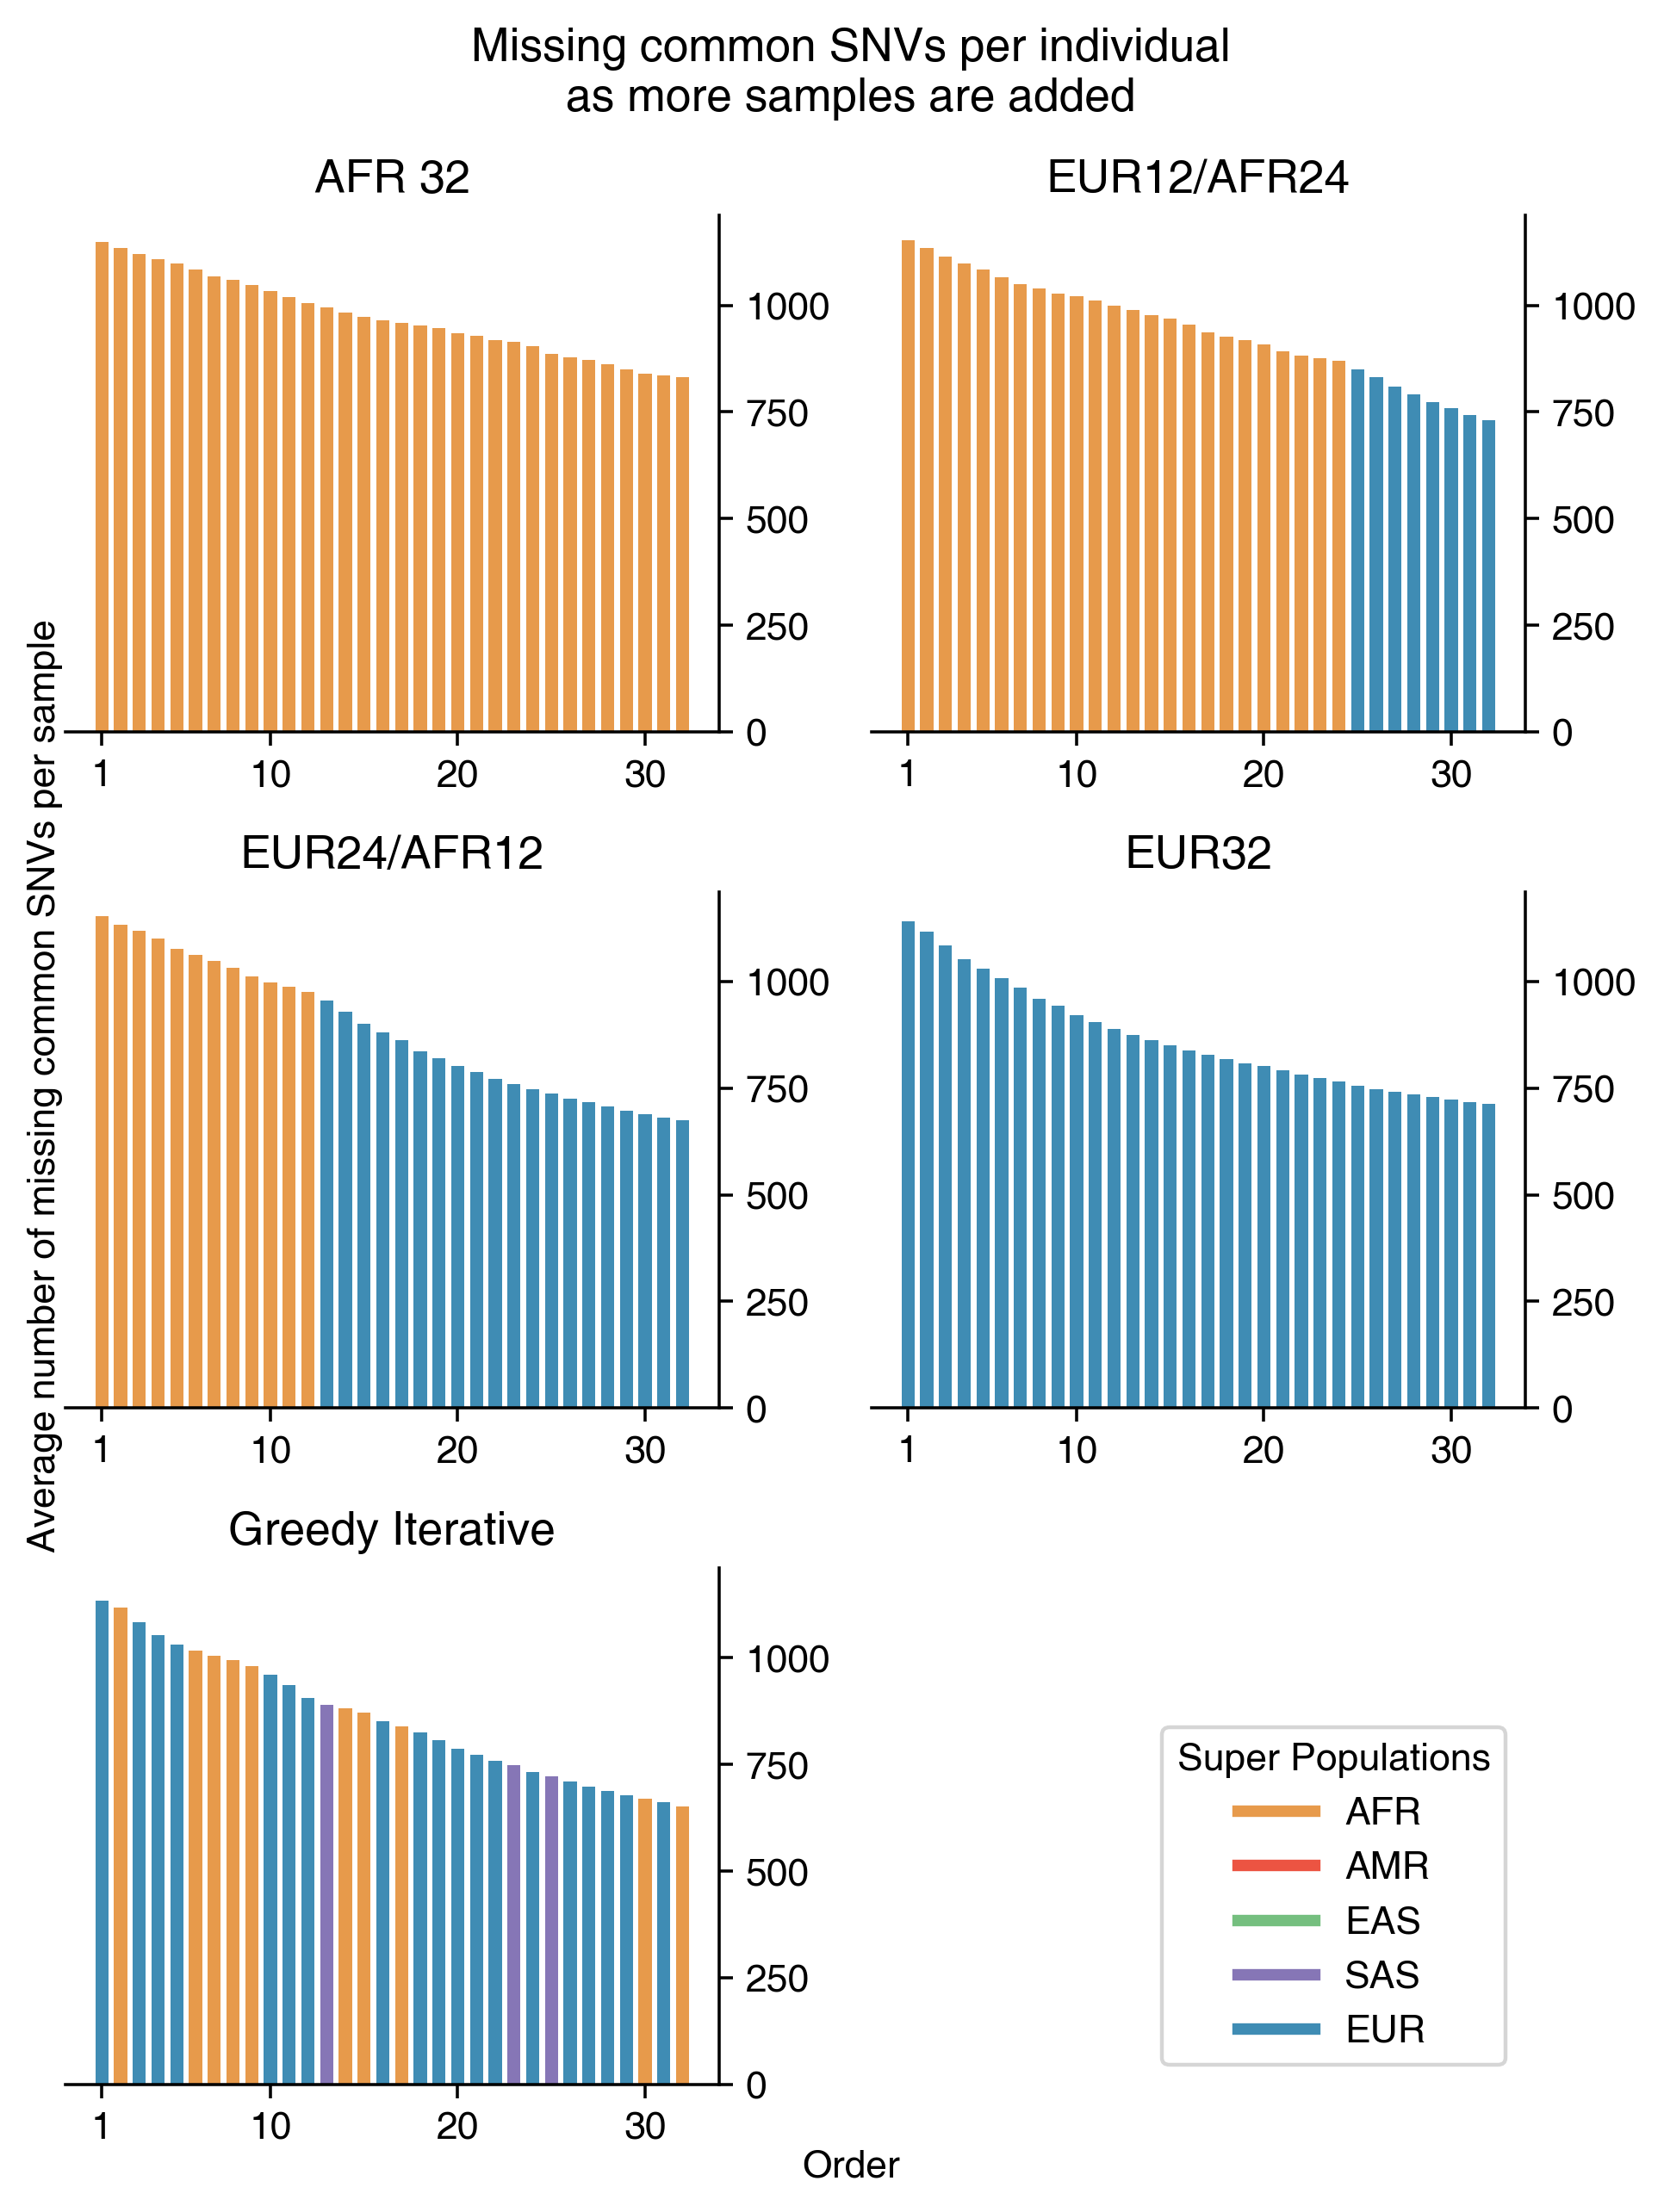

In [19]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,dpi=320,sharey=True,figsize=(6,8))
ax_list = ax_list.flatten()
width = 0.7
for index,strat in enumerate(iterative_newones.keys()):

    ax = ax_list[index]
    means = improvements[strat].mean(axis=1)
    std = improvements[strat].std(axis=1)
    
    x = np.arange(improvements[strat].shape[0])+1
    ax.bar(x , means, width = width,color=popinfo[strat]['super_colors'].values)
    ax.set_title(strat)
    
#     for xval in x:
#         ax.scatter(xval,yvals[xval-1],marker=popinfo[strat]['marker'].values[xval-1])#,color=colors[index])
    
    if index == 0 or index == 2:
#         pass
#         ax.axes.get_yaxis().set_visible(False)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    else:
        
        ax.axes.get_yaxis().set_visible(True)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    ax.set_xticks([1,10,20,30])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    print(strat)
fig.suptitle('Missing common SNVs per individual\n'+
            'as more samples are added')

fig.text(0.5, 0.005, 'Order', ha='center')
fig.text(0.002, 0.5, 'Average number of missing common SNVs per sample', va='center', rotation='vertical')

ax_list[-1].axis('off')
second_legend_elements = []
for item in color_dict_super:
    second_legend_elements.append(Line2D([0],[0],color=color_dict_super[item],label=item,
                                        linewidth=3))
ax_list[-1].legend(handles=second_legend_elements, loc='lower right',title="Super Populations")
fig.tight_layout()




AFR 32
EUR12/AFR24
EUR24/AFR12
EUR32
Greedy Iterative


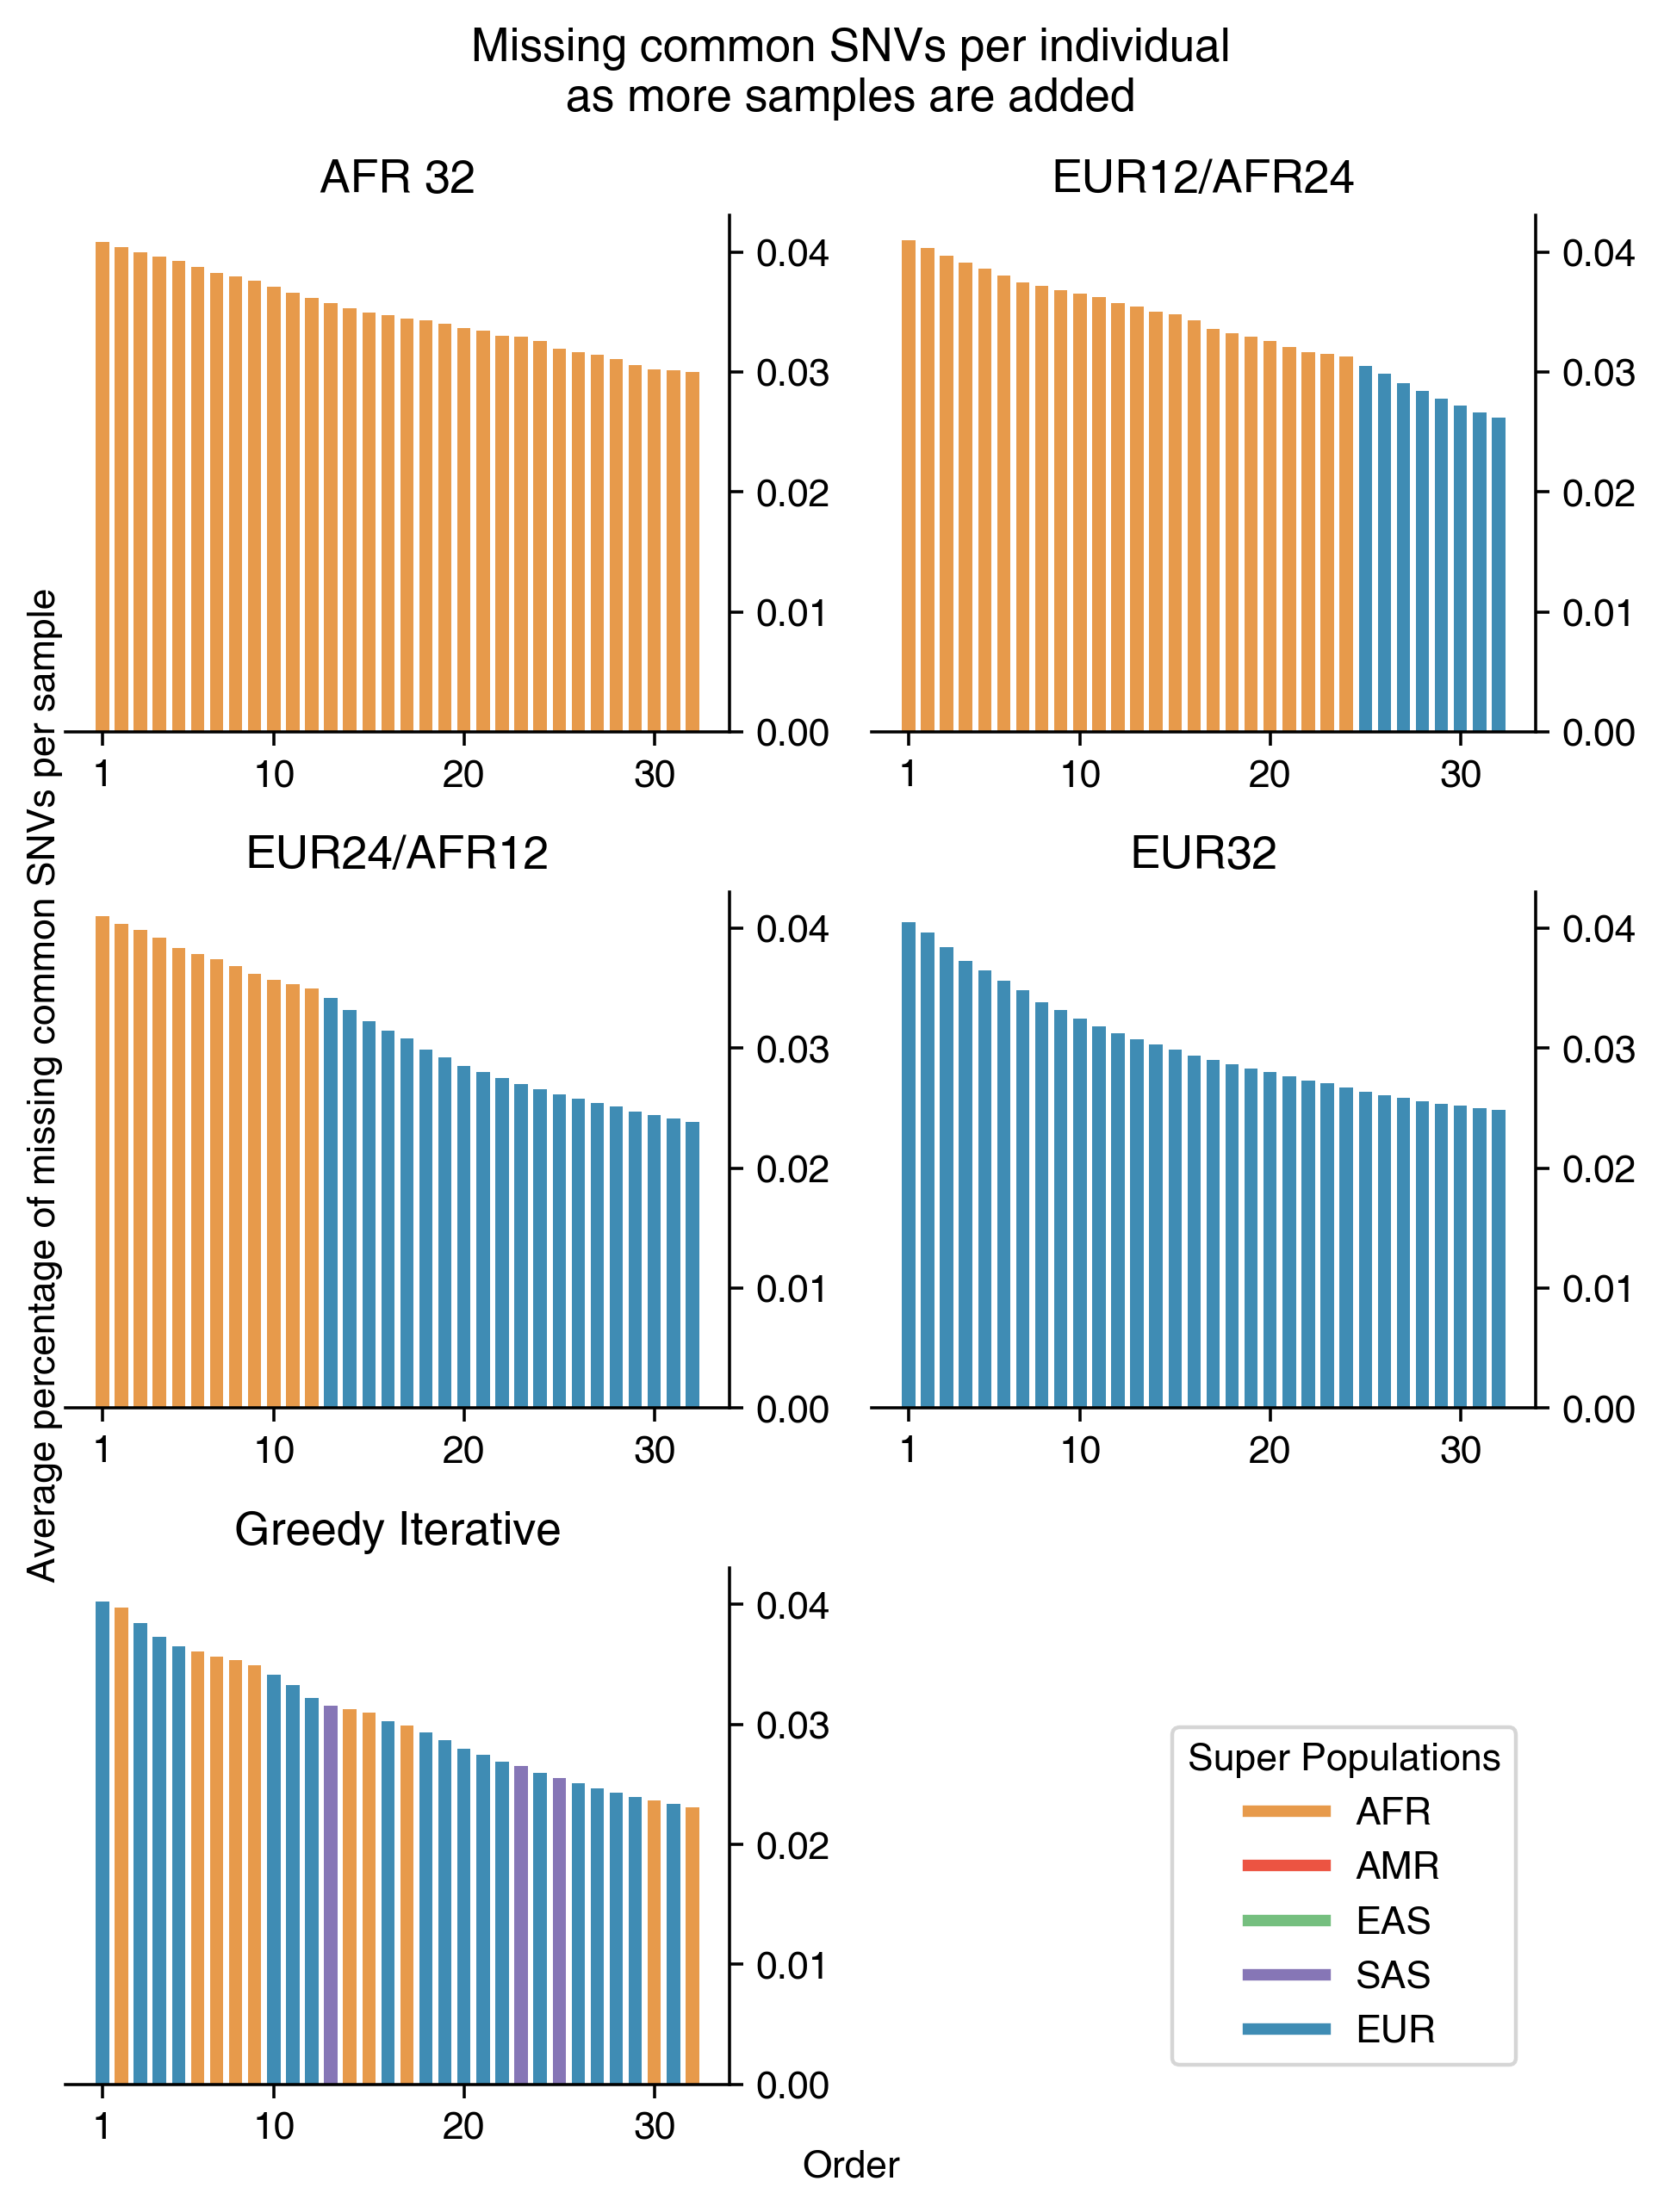

In [20]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,dpi=320,sharey=True,figsize=(6,8))
ax_list = ax_list.flatten()
width = 0.7
for index,strat in enumerate(iterative_newones.keys()):

    ax = ax_list[index]
    means = improvements_percent[strat].mean(axis=1)
    std = improvements_percent[strat].std(axis=1)
    
    x = np.arange(improvements_percent[strat].shape[0])+1
    ax.bar(x , means, width = width,color=popinfo[strat]['super_colors'].values)
    ax.set_title(strat)
    
#     for xval in x:
#         ax.scatter(xval,yvals[xval-1],marker=popinfo[strat]['marker'].values[xval-1])#,color=colors[index])
    
    if index == 0 or index == 2:
#         pass
#         ax.axes.get_yaxis().set_visible(False)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    else:
        
        ax.axes.get_yaxis().set_visible(True)
        ax.yaxis.set_tick_params(which='both', labelbottom=True)
        ax.yaxis.tick_right()
    ax.set_xticks([1,10,20,30])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    print(strat)
fig.suptitle('Missing common SNVs per individual\n'+
            'as more samples are added')

fig.text(0.5, 0.005, 'Order', ha='center')
fig.text(0.002, 0.5, 'Average percentage of missing common SNVs per sample', va='center', rotation='vertical')

ax_list[-1].axis('off')
second_legend_elements = []
for item in color_dict_super:
    second_legend_elements.append(Line2D([0],[0],color=color_dict_super[item],label=item,
                                        linewidth=3))
ax_list[-1].legend(handles=second_legend_elements, loc='lower right',title="Super Populations")
fig.tight_layout()



